# ViTMAE

- [paper: Masked Autoencoders are Scalable Vision Learners](https://arxiv.org/pdf/2111.06377.pdf)
- code: [facebookresearch/mae](https://github.com/facebookresearch/mae/blob/main/models_mae.py)

### Simplifications:
- no [CLS] token

In [103]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [104]:
config = {
    'patch_size': 16,
    'img_size': 224,
    'dim': 256,
    'num_channels': 3,
    'num_heads': 8,
    'attn_drop': 0.1,
    'mlp_drop': 0.1,
    'pos_drop': 0.1,
    'encoder_depth': 6,
    'decoder_depth': 4,
    'decoder_dim': 128
}

## Patch Embedding Layer

In [105]:
class PatchEmbedding(nn.Module):
    def __init__(self,**config):
        super().__init__()
        self.patch_size = config['patch_size']
        self.img_size = config['img_size']
        self.grid_size = self.img_size // self.patch_size
        self.num_patches = self.grid_size ** 2
        self.dim = config['dim']
        
        self.proj = nn.Conv2d(
            config['num_channels'],
            self.dim,
            kernel_size=self.patch_size,
            stride=self.patch_size
        )
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).permute(0,2,1) # b,dim,h,w -> b,h*w,dim
        return x

## ViT Block

In [106]:
class ViTBlock(nn.Module):
    def __init__(self,is_decoder=False,**config):
        super().__init__()
        
        dim = config['decoder_dim'] if is_decoder else config['dim']
        assert dim % config['num_heads'] == 0, 'dim%num_heads!=0'
        
        self.dim = dim
        self.num_heads = config['num_heads']
        self.attn = nn.MultiheadAttention(
            embed_dim=self.dim,
            num_heads=self.num_heads,
            batch_first=True,
            dropout=config['attn_drop']
        )
        self.mlp = nn.Sequential(
            nn.Linear(self.dim,self.dim*4),
            nn.GELU(),
            nn.Dropout(config['mlp_drop']),
            nn.Linear(self.dim*4,self.dim)
        )
        self.ln1 = nn.LayerNorm(self.dim)
        self.ln2 = nn.LayerNorm(self.dim)
        
    def forward(self,x):
        x = self.ln1(x)
        x = x + self.attn(x,x,x)[0]
        x = x + self.mlp(self.ln2(x))
        return x

## 2D Positional Sinusoidal Embeddings

In [107]:
def get_1d_embed_from_grid(dim,pos):
    '''
    dim: embedding dim
    pos: list of positions to be encoded (M,)
    
    output: (M,D)
    '''
    assert dim%2==0
    
    omega = np.arange(dim//2,dtype=np.float32)
    omega /= dim/2.
    omega = 1./10000 ** omega # (D/2,)
    
    pos = pos.reshape(-1)
    out = np.einsum('m,d->md',pos, omega) # outer product (M,D/2)
    
    sin = np.sin(out)
    cos = np.cos(out)
    
    out = np.concatenate([sin,cos],axis=1) # (M/D)
    return out

In [108]:
out = get_1d_embed_from_grid(256,np.arange(196))

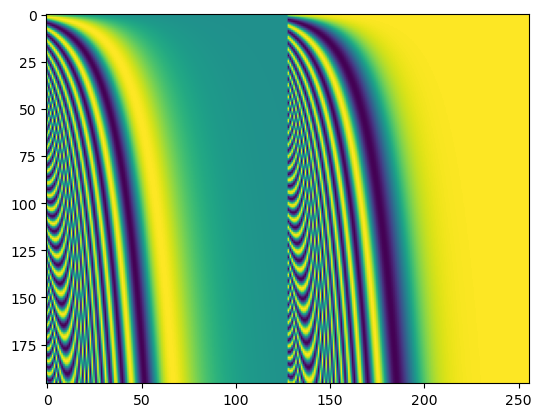

In [109]:
plt.imshow(out)

In [110]:
def get_2d_sincos_pos_embed_from_grid(dim, grid):
    assert dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_embed_from_grid(dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_embed_from_grid(dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

In [111]:
def get_2d_sincos_pos_embed(dim, grid_size):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, dim]
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(dim, grid)
    return pos_embed

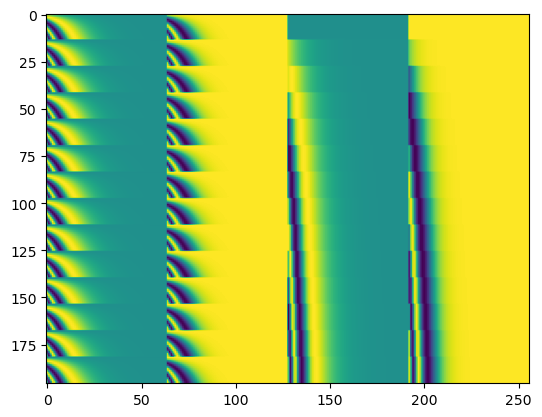

In [112]:
plt.imshow(get_2d_sincos_pos_embed(256,14))

In [113]:
class ViTMAE(nn.Module):
    def __init__(self,**config):
        super().__init__()
        
        self.config = config
        
        self.patch_embed = PatchEmbedding(**config)
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1,num_patches,config['dim']),requires_grad=False)
        
        self.blocks = nn.ModuleList([
            ViTBlock(**config) for _ in range(config['encoder_depth'])
        ])
        
        self.encoder_norm = nn.LayerNorm(config['dim'])
        
        # MAE stuff
        
        self.decoder_embed = nn.Linear(config['dim'],config['decoder_dim'])
        
        self.mask_token = nn.Parameter(torch.zeros(1,1,config['decoder_dim']))
        
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1,num_patches,config['decoder_dim']),requires_grad=False)
        
        self.decoder_blocks = nn.ModuleList([
            ViTBlock(is_decoder=True,**config) for _ in range(config['decoder_depth'])
        ])
        
        self.decoder_norm = nn.LayerNorm(config['decoder_dim'])
        
        out_features = config['patch_size'] ** 2 * config['num_channels']
        
        self.decoder_head = nn.Linear(config['decoder_dim'],out_features)
        
        self.initialize_weights()
        
    def initialize_weights(self):
        
        pos_embed = get_2d_sincos_pos_embed(
            self.pos_embed.shape[-1],
            int(self.patch_embed.num_patches**.5)
        )
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(
            self.decoder_pos_embed.shape[-1], 
            int(self.patch_embed.num_patches**.5)
        )
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))
        torch.nn.init.normal_(self.mask_token, std=.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def random_masking(self, x, mask_ratio=0.75):
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def patchify(self,imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        c = self.config['num_channels']
        p = self.patch_embed.patch_size
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], c, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * c))
        return x
    
    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        c = self.config['num_channels']
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs
    
    def forward_encoder(self, x):
        
        x = self.patch_embed(x)
        x = x + self.pos_embed
        
        x, mask, ids_restore = self.random_masking(x)
        
        for block in self.blocks:
            x = block(x)
            
        x = self.encoder_norm(x)
        
        return x, mask, ids_restore
    
    def forward_decoder(self,x,ids_restore):
        
        x = self.decoder_embed(x)
        mask_tokens = self.mask_token.repeat(
            x.shape[0], ids_restore.shape[1] - x.shape[1], 1
        )
        x_ = torch.cat([x,mask_tokens],dim=1)
        
        #unshuffle
        x = torch.gather(x_,dim=1,index=ids_restore.unsqueeze(-1).repeat(1,1,x.shape[2]))
        
        x = x+self.decoder_pos_embed
        
        for block in self.decoder_blocks:
            x = block(x)
            
        x = self.decoder_head(x)
        
        return x
    
    
    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss
    
    def forward(self, imgs):
        latent, mask, ids_restore = self.forward_encoder(imgs)
        preds = self.forward_decoder(latent,ids_restore)
        loss = self.forward_loss(imgs,preds,mask)
        return loss, preds, mask
    

In [114]:
m = ViTMAE(**config)

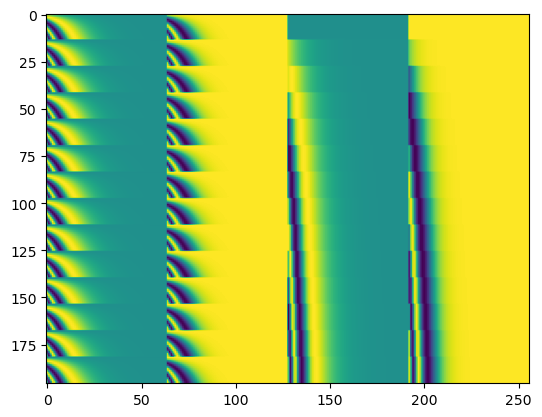

In [115]:
plt.imshow(m.pos_embed.squeeze().numpy())

In [116]:
out = m(torch.rand(1,config['num_channels'],224,224))
out[0], out[1].shape, out[2].shape

(tensor(0.8202, grad_fn=<DivBackward0>),
 torch.Size([1, 196, 768]),
 torch.Size([1, 196]))